In [1]:
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as Func
from torch.autograd import Variable
from torchinfo import summary

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

from torch.utils.data import Dataset, DataLoader
from torchinfo import summary

from tqdm.auto import tqdm

# own
import common.action as action
import common.world as world
import common.plot as plot
import common.preprocess as preprocess
import common.nets as nets
import common.train as train
import common.tools as tools

/Users/mariuskaestingschaefer/miniforge3/envs/pytorch/lib/python3.8/site-packages/seaborn/rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/Users/mariuskaestingschaefer/miniforge3/envs/pytorch/lib/python3.8/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/Users/mariuskaestingschaefer/miniforge3/envs/pytorch/lib/python3.8/site-packages/torch/utils/tensorboard/__init__.py:6: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, '__version__') or LooseVersion(tensorboard.__version__) < LooseVersion('1.15'):


In [2]:
with open("datasets/oracle_data.pickle", "rb") as handle:
    oracle_data = pickle.load(handle)

with open("datasets/oracle_reversed_data.pickle", "rb") as handle:
    oracle_reversed_data = pickle.load(handle)

with open("datasets/oracle_random_data.pickle", "rb") as handle:
    oracle_random_data = pickle.load(handle)

with open("datasets/oracle_reversed_random_data.pickle", "rb") as handle:
    oracle_reversed_random_data = pickle.load(handle)

with open("datasets/random_data.pickle", "rb") as handle:
    random_data = pickle.load(handle)

with open("datasets/tmaze_random_reverse_data.pickle", "rb") as handle:
    tmaze_random_reverse_data = pickle.load(handle)

with open("datasets/oracle_reversed_random_data_small.pickle", "rb") as handle:
    oracle_reversed_random_data_small = pickle.load(handle)

In [3]:
positions = oracle_data['positions']

coords = [[i[0], i[2]] for i in positions]

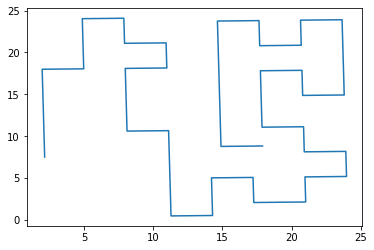

In [4]:
from matplotlib import pyplot as plt

x, y = [], []
for coord in coords:
    x.append(coord[0])
    y.append(coord[1])

plt.plot(x, y)
plt.show()

In [15]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data) - seq_length - 1):
        _x = data[i : (i + seq_length)]
        _y = data[i + seq_length]  # _y = data[i+seq_length] (target)
        x.append(_x)
        y.append(_y)

    return np.array(x), np.array(y)  # train, val. data

training_data = coords


seq_length = 10
shuffle = True

x, y = sliding_windows(training_data, seq_length)

# one method of performing the training and validation split
train_size = int(len(y) * 0.80)
test_size = len(y) - train_size


# shuffle data first before splitting
if shuffle:
    idx_shuf = list(range(len(y)))
    random.shuffle(idx_shuf)
    x = [x[i] for i in idx_shuf]
    y = [y[i] for i in idx_shuf]

# split data
dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size : len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size : len(y)])))

In [16]:
k = 6
print('sequence:', x[k])
print('label:', y[k])

print(len(y))

sequence: [[15.53660442 23.76744356]
 [15.38662652 23.76486859]
 [15.23664862 23.76229363]
 [15.08667073 23.75971866]
 [14.93669283 23.75714369]
 [14.78671493 23.75456872]
 [14.63673704 23.75199376]
 [14.63673704 23.75199376]
 [14.63673704 23.75199376]
 [14.63673704 23.75199376]]
label: [14.63673704 23.75199376]
1184


In [17]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()

        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
        )

        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))

        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        h_out = h_out.view(-1, self.hidden_size)
        out1 = self.fc(h_out)
        #out2 = self.fc(h_out)

        return out1 #, out2

# change weight initialization (kaiming_normal_
    
num_epochs = 2000
learning_rate = 0.001

input_size = 2
hidden_size = 20
num_layers = 1

num_classes = 2

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

In [18]:
value = 0

test_input = trainX[value:value+1]
print("input length:", len(test_input[0]))
print("input (trainX):", test_input)

#out1, out2 = lstm(test_input)
out1 = lstm(test_input)
print(out1)

print("outputs:", out1[0]) #
print("labels:", trainY[value:value+1])

print("")

#out1, out2 = lstm(trainX)
out1 = lstm(trainX)

print("length input (trainX):", len(trainX))
print("length outputs:", len(out1))
print("length labels:", len(trainY))

print("")
print("SUMMARY LSTM \n", summary(lstm, (600, 1, 2), device="cpu"))

input length: 10
input (trainX): tensor([[[11.5864,  0.4462],
         [11.7363,  0.4488],
         [11.8863,  0.4513],
         [12.0363,  0.4539],
         [12.1863,  0.4565],
         [12.3363,  0.4591],
         [12.4862,  0.4616],
         [12.6362,  0.4642],
         [12.7862,  0.4668],
         [12.9362,  0.4694]]])
tensor([[-0.0138, -0.3307]], grad_fn=<AddmmBackward0>)
outputs: tensor([-0.0138, -0.3307], grad_fn=<SelectBackward0>)
labels: tensor([[13.0861,  0.4719]])

length input (trainX): 947
length outputs: 947
length labels: 947

SUMMARY LSTM 
Layer (type:depth-idx)                   Output Shape              Param #
LSTM                                     [600, 2]                  --
├─LSTM: 1-1                              [600, 1, 20]              1,920
├─Linear: 1-2                            [600, 2]                  42
Total params: 1,962
Trainable params: 1,962
Non-trainable params: 0
Total mult-adds (M): 1.18
Input size (MB): 0.00
Forward/backward pass size (MB): 0

In [19]:
def separate_coordinates(coords):

    coord1, coord2 = [], []
    for coord in coords:
        coord1.append(coord[0].tolist() * 10)
        coord2.append(coord[1].tolist() * 10)
        #coord2 = coord2 + list(coord[1].tolist())
        
    coord1 = torch.FloatTensor(coord1)
    coord2 = torch.FloatTensor(coord2)
        
    return coord1, coord2

coord1_trainY, coord2_trainY =  separate_coordinates(trainY)
coord1_testY, coord2_testY =  separate_coordinates(testY)

In [20]:

#criterion = torch.nn.MSELoss()  # MSELoss - regression, CrossEntropyLoss for labels
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

num_epochs = 2000

# Train the model
for epoch in range(num_epochs):
    
    optimizer.zero_grad()
    output = lstm(trainX)
    loss = criterion(output, trainY)
    loss.backward()
    
    # compute euclidean distance 
    if epoch % (num_epochs/20) == 0:
        train_dist = 0
        for idx, _ in enumerate(trainY):
            train_dist += ((output[idx][0] - trainY[idx][0])**2 + (output[idx][1] - trainY[idx][1])**2) ** 0.5
        train_dist = train_dist/len(trainY)

    with torch.no_grad():
        output_test = lstm(testX)
        loss_test = criterion(output_test, testY)
        
        if epoch % (num_epochs/20) == 0:
            test_dist = 0
            for idx, _ in enumerate(testY):
                test_dist += ((output_test[idx][0] - testY[idx][0])**2 + (output_test[idx][1] - testY[idx][1])**2) ** 0.5
            test_dist = test_dist/len(testY)
        
    optimizer.step()
    if epoch % (num_epochs/20) == 0:
        print("Epoch: %d, train loss: %1.5f, train distance: %1.5f, test loss: %1.5f, test distance: %1.5f" % (epoch, loss.item(), train_dist, loss_test.item(), test_dist))
      
        

Epoch: 0, train loss: 256.97858, train distance: 21.88476, test loss: 247.71519, test distance: 21.57553
Epoch: 100, train loss: 174.45572, train distance: 17.79860, test loss: 167.80641, test distance: 17.56754
Epoch: 200, train loss: 119.60197, train distance: 14.53815, test loss: 114.88889, test distance: 14.39939
Epoch: 300, train loss: 87.38197, train distance: 12.29462, test loss: 84.15797, test distance: 12.25662
Epoch: 400, train loss: 67.98599, train distance: 10.76284, test loss: 65.88870, test distance: 10.81106
Epoch: 500, train loss: 54.50697, train distance: 9.58704, test loss: 53.17038, test distance: 9.66778
Epoch: 600, train loss: 44.89470, train distance: 8.64979, test loss: 44.26009, test distance: 8.77455
Epoch: 700, train loss: 37.76913, train distance: 7.89899, test loss: 37.74602, test distance: 8.06953
Epoch: 800, train loss: 32.01662, train distance: 7.21833, test loss: 32.39474, test distance: 7.42499
Epoch: 900, train loss: 27.30695, train distance: 6.59175, 